### Dimensionality Reduction
A widely encountered problem in machine learning is that of dimensionality. We typically refer to the size or shape of a dataset as an $n$ x $p$ matrix, where each row from 1 to $n$ represents an observation, or data point, and each column from 1 to $p$ represents a variable, or feature. With each additional feature, the dimensionality of a dataset increases by 1.

The problems with increasing or high levels of dimensionality are as follows:

- More storage space required for the data;
- More computation time required to work with the data; and
- More features means more chance of feature correlation, and hence feature redundancy.

The latter point is the basis on which **principal component analysis** is carried out. A feature that is highly correlated with another increases when the other increases (positive correlation), or decreases when the other increases (negative correlation). This is helpful, because if multiple features tend to behave in a corresponding manner in the dataset, they can often be replaced by some smaller quantity of representative feature(s). This helps to lower the feature space within which the data reside, reducing computation time as well as storage capacity requirements.

The goal of dimensionality reduction is to reduce the number of features in a dataset while minimising the amount of data loss. There are three primary methods by which this can be done:

- Principal Component Analysis (PCA);
- Linear Discriminant Analysis (LDA); and
- Generalised Discriminant Analysis (GDA).

In this notebook we will focus on PCA.

## Principal Component Analysis
The premise of PCA is that data in some higher number of dimensions can be mapped to some lower number of dimensions, whilst retaining the maximum amount of variance in the lower dimension. Broadly speaking, the following steps are involved in a PCA:

1. Construct the covariance matrix of the data;
2. Compute the eigenvectors of this matrix; and
3. Eigenvectors corresponding to the largest eigenvalues are used to reconstruct a maximal fraction of variance of the original data.

These are unfamiliar terms which we encourage you to go and investigate on your own. The general idea is that we are able to compute a vector within the feature space of the dataset, which points in the direction of the maximum variance found in the data. This vector is known as the principal component, and we say that it _explains_ the most variance.

The second principal component is that vector which is orthogonal (mutually perpendicular) to the first principal component, and which again explains the maximum variance in this orthogonal direction. The third principal component is orthogonal to both of the first two, and explains the maximum variance in that direction.

This continues for each additional principal component, until the maximum number of $p$ principal components (there cannot be more principal components than there are features). 100% of the variance can only be explained by all $p$ of the features, so we do expect that in reducing the number of dimensions we will lose _some_ data. However, because the principal components are orthogonal and ranked in decreasing order of variance explained, we do normally expect that some subset of all the features will explain a significant proportion of the data.

Let's apply this method of dimensionality reduction to a real dataset.

### Applying PCA to Real Data

The dataset we will make use of is from the US census of 2015. It contains demographic information such as population, proportion of race, gender, income, child poverty, etc, for each county in the US. A county is a geographic area which is larger than a city but smaller than a state. There are over 3000 counties in the dataset, which should provide sufficient information to perform PCA with.

Let's start this example by importing all the packages we'll need, then bring in the data, and see what it looks like.

In [2]:

# help(cf)

In [3]:
# !pip install cufflinks

In [4]:
# Data Analysis llibraries
import pandas as pd
import numpy as np

# other
import os

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

# Figures inline and set visualization style
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Machine Learning
import surprise
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## 1.2 Import Datasets

In [5]:
# List all files in a directory using os.listdir
basepath = '../../input/'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        print(entry)

train.csv
imdb_data.csv
genome_scores.csv
test.csv
genome_tags.csv
sample_submission.csv
movies.csv
links.csv
tags.csv


Expected Data sets

* `genome_scores.csv` - a score mapping the strength between movies and tag-related properties. Read more [here](http://files.grouplens.org/papers/tag_genome.pdf)
* `genome_tags.csv` - user assigned tags for genome-related scores
* `imdb_data.csv` - Additional movie metadata scraped from IMDB using the links.csv file.
* `links.csv` - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
* `sample_submission.csv` - Sample of the submission format for the hackathon.
* `tags.csv` - User assigned for the movies within the dataset.
* `test.csv` - The test split of the dataset. Contains user and movie IDs with no rating data.
* `train.csv` - The training split of the dataset. Contains user and movie IDs with associated rating data.


In [6]:
# import Training, Testing and Submission Data
train_df = pd.read_csv(basepath + 'train.csv', nrows=50000)
test_df = pd.read_csv(basepath + 'test.csv', nrows=50000)
# sample_submission_df = pd.read_csv(basepath + 'sample_submission.csv')

# User - Movie relationship
genome_scores_df = pd.read_csv(basepath + 'genome_scores.csv', nrows=50000)
genome_tags_df = pd.read_csv(basepath + 'genome_tags.csv')

# Other Data to be explored
movies_df = pd.read_csv(basepath + 'movies.csv')
imdb_data_df = pd.read_csv(basepath + 'imdb_data.csv')
links_df = pd.read_csv(basepath + 'links.csv')
tags_df = pd.read_csv(basepath + 'tags.csv', nrows=50000)

### Machine Learning Data

All ratings are contained in the file `train.csv.` Each line of this file after the header row represents one rating of one movie by one user, and has the following format:
```
userId,movieId,rating,timestamp
```

* The lines within this file are ordered first by userId, then, within user, by movieId.
* Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
* Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [7]:
print(train_df.shape)
train_df.head()

(50000, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
print(test_df.shape)
test_df.head()

(50000, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [9]:
# print(sample_submission_df.shape)
# sample_submission_df.head()

### Other Data

Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:
```
movieId,title,genres
```
Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.
Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [10]:
print(movies_df.shape)
movies_df.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
print(imdb_data_df.shape)
imdb_data_df.head()

(27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


As described in [this article](http://files.grouplens.org/papers/tag_genome.pdf), the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

The genome is split into two files. The file `genome-scores.csv` contains movie-tag relevance data in the following format:
```
movieId,tagId,relevance
```

In [12]:
print(genome_scores_df.shape)
genome_scores_df.head()

(50000, 3)


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


The second file, `genome-tags.csv`, provides the tag descriptions for the tag IDs in the genome file, in the following format:
```
tagId,tag
```

In [13]:
print(genome_tags_df.shape)
genome_tags_df.head()

(1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format:
```
movieId,imdbId,tmdbId
```
movieId is an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.

imdbId is an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.

tmdbId is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862.

Use of the resources listed above is subject to the terms of each provider.

In [14]:
print(links_df.shape)
links_df.head()

(62423, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:
```
userId,movieId,tag,timestamp
```

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

In [15]:
print(tags_df.shape)
tags_df.head()

(50000, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


## Merging Tables

We will be joining the *utility matrix*, `train_df` and `test_df`, to:
1. *movies* - `movies_df`
2. *imbd* - `imbd_data_df`
3. *genome_score* and *genome_tag* - `genome_score_df` and `genome_tag_df`
4. *tags* - `tags_df`

**Movies**

Content data:
* get number of movies with genre
* get number of times other genres appeared as well
* get the year of the movie

user data:
* get list of ratings associated with genre
* get the time stamp


In [16]:
movies_df['year'] = movies_df.title.str.extract("\((\d{4})\)", expand=True)
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [32]:
movies_df['year'].describe()

count     62013
unique      135
top        2015
freq       2513
Name: year, dtype: object

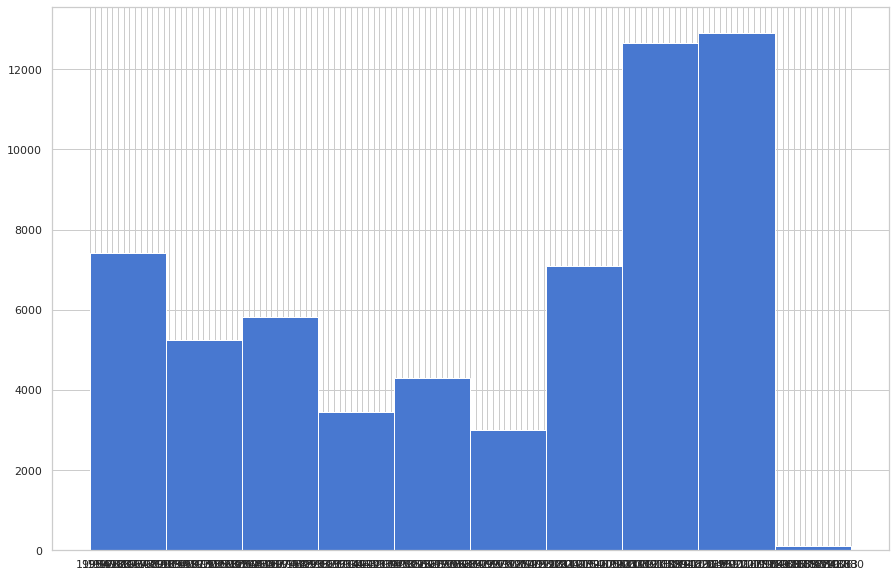

In [33]:
movies_df['year'].hist()

The genres column has a lot of data

In [17]:
movies_df['number of genres'] = movies_df['genres'].apply(lambda x: x.count('|') + 1)
movies_df.head()

,movieId,title,genres,year,number of genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3
4,5,Father of the Bride Part II (1995),Comedy,1995,1


We are going to investigate the genres data a step further
* 1 of the things we observe is that the there are differing combinations of genre's
* Another thing is that the movie titles have associated release years.

In [27]:
movies_df['number of genres'].describe()

count    62423.000000
mean         1.799129
std          0.963300
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: number of genres, dtype: float64

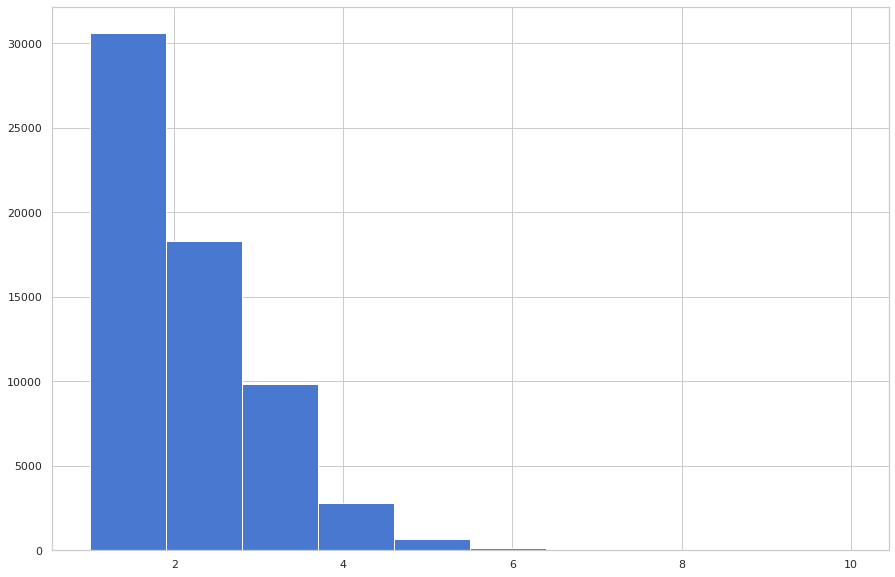

In [31]:
movies_df['number of genres'].hist()

In [34]:
movies_df['genres_list'] = movies_df['genres'].apply(lambda x: x.split('|'))
movies_df.head()

,movieId,title,genres,year,number of genres,genres_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,1995,1,[Comedy]


To investigate the genres better we will "normalise" the `genres` column of the `movies_df` dataframe to 1NF

In [37]:
genres_map = movies_df[['movieId', 'genres_list']].explode('genres_list')
genres_map.head()

,movieId,genres_list
0,1,Adventure
0,1,Animation
0,1,Children
0,1,Comedy
0,1,Fantasy


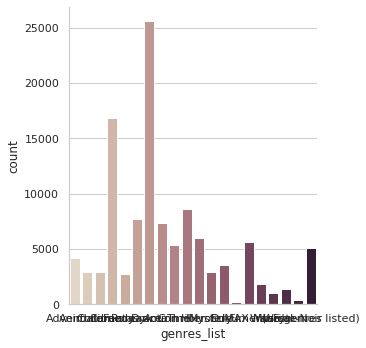

In [38]:

_ = sns.catplot(x="genres_list", kind="count", palette="ch:.25", data=genres_map)

plt.tight

In [30]:
# create a table to map the movies to the genres
map_genres_arr = np.empty((0,2))

# for each genre in the movies dataframe row
# create a new row with movie id and genre


array([], shape=(0, 2), dtype=float64)

In [18]:
# Merge Uitility Matrix with Movies Data with
util_movies_df = pd.merge(train_df, movies_df, how='left', on='movieId')
util_movies_df.head()

,userId,movieId,rating,timestamp,title,genres,year,number of genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,2008,4
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,1995,1
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,2002,3
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,2005,3
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,1994,4


In [19]:
util_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userId            50000 non-null  int64  
 1   movieId           50000 non-null  int64  
 2   rating            50000 non-null  float64
 3   timestamp         50000 non-null  int64  
 4   title             50000 non-null  object 
 5   genres            50000 non-null  object 
 6   year              49978 non-null  object 
 7   number of genres  50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.4+ MB


In [20]:
util_movies_df.describe()

,userId,movieId,rating,timestamp,number of genres
count,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.0000
mean,81318.904260,21386.026840,3.534680,1.215440e+09,2.7156
std,46971.405087,39199.155907,1.063414,2.267091e+08,1.1850
min,2.000000,1.000000,0.500000,8.231852e+08,1.0000
25%,40636.000000,1197.000000,3.000000,1.012304e+09,2.0000
50%,81268.500000,2932.000000,4.000000,1.199372e+09,3.0000
75%,121851.250000,8623.000000,4.000000,1.447112e+09,3.0000
max,162541.000000,208889.000000,5.000000,1.574328e+09,10.0000


In [21]:
util_movies_df['genres'].apply(lambda x: x.split('|'))

0                         [Comedy, Crime, Drama, Thriller]
1                                                 [Comedy]
2                                 [Action, Comedy, Sci-Fi]
3                               [Adventure, Comedy, Crime]
4                       [Drama, Horror, Mystery, Thriller]
                               ...                        
49995                                     [Drama, Romance]
49996                                           [Thriller]
49997                                    [Drama, Thriller]
49998                                      [Drama, Sci-Fi]
49999    [Animation, Children, Fantasy, Musical, Romanc...
Name: genres, Length: 50000, dtype: object

In [22]:
bag_of_genres = {}
genres_watched = util_movies_df.genres.str.split('|').values
genres_watched

array([list(['Comedy', 'Crime', 'Drama', 'Thriller']), list(['Comedy']),
       list(['Action', 'Comedy', 'Sci-Fi']), ...,
       list(['Drama', 'Thriller']), list(['Drama', 'Sci-Fi']),
       list(['Animation', 'Children', 'Fantasy', 'Musical', 'Romance', 'IMAX'])],
      dtype=object)

In [23]:
for i, genre_list in enumerate(genres_watched):
    for genre in genre_list:
        if genre in bag_of_genres.keys():
            bag_of_genres[genre] += 1
            
        else:
            bag_of_genres[genre] = 1
            

In [24]:
bag_of_genres

{'Comedy': 17798,
 'Crime': 8380,
 'Drama': 21999,
 'Thriller': 13550,
 'Action': 14960,
 'Sci-Fi': 8679,
 'Adventure': 11608,
 'Horror': 3779,
 'Mystery': 4059,
 'Fantasy': 5683,
 'Animation': 3283,
 'Children': 4374,
 'Romance': 8991,
 'IMAX': 2129,
 'War': 2516,
 'Western': 915,
 'Musical': 1969,
 'Documentary': 609,
 'Film-Noir': 443,
 '(no genres listed)': 56}

In [25]:
dict_of_genres = {}

for 

SyntaxError: invalid syntax (<ipython-input-25-cdbe1a164574>, line 3)

In [ ]:
plt.hist(bag_of_genres.keys(), bag_of_genres.values())
plt.show()

In [ ]:
pd.DataFrame(util_movies_df.genres.str.split('|').tolist()).stack()

In [ ]:
# # Create bee swarm plot with Seaborn's default settings
# _ = sns.violinplot(x='genres', y='rating', data=util_movies_df)

# # Label the axes
# _ = plt.xlabel('genres')
# _ = plt.ylabel('rating')

# # Show the plot
# plt.show()

In [ ]:
# Merge Uitility Matrix with Imdb data
util_imdb_df = pd.merge(train_df, imdb_data_df, how='left', on='movieId')
util_imdb_df.head()

In [ ]:
# Merge Utility Matrix with genome data
merged_genome_df = pd.merge(genome_scores_df, genome_tags_df, how='left', on='tagId')
util_genome_df = pd.merge(train_df, merged_genome_df, how='left', on='movieId')
util_genome_df.head()

In [ ]:
# Merge Uitility Matrix with tags data
util_tags_df = pd.merge(train_df, tags_df, how='left', on='movieId')
util_tags_df.head()